In [1]:
#Image based prediction

import pandas as pd

# Load the cleaned movie dataset
df = pd.read_csv("strictly_balanced_top10_cleaned.csv")

print("✅ Dataset loaded successfully!")
print(f"📦 Total movies in dataset: {len(df)}")

# Check available columns
print("\n🧱 Columns:")
print(df.columns.tolist())



✅ Dataset loaded successfully!
📦 Total movies in dataset: 111630

🧱 Columns:
['id', 'genres', 'overview', 'poster_path', 'keywords', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'poster_url', 'clean_overview']


In [2]:
# Keep only rows where poster_url is not missing
df_with_posters = df.dropna(subset=['poster_url'])

print(f"🎬 Movies with valid poster URLs: {len(df_with_posters)}")


🎬 Movies with valid poster URLs: 111630


In [3]:
# Shuffle the dataframe first
mini_df = df_with_posters.sample(n=2000, random_state=42).reset_index(drop=True)

print(f"✅ Randomly sampled {len(mini_df)} movies for mini poster dataset.")


✅ Randomly sampled 2000 movies for mini poster dataset.


In [4]:
import os
import requests
from tqdm import tqdm

save_folder = "mini_posters"
os.makedirs(save_folder, exist_ok=True)

poster_urls = mini_df['poster_url'].tolist()

for url in tqdm(poster_urls, desc="Downloading mini posters"):
    try:
        filename = url.split("/")[-1]
        save_path = os.path.join(save_folder, filename)

        if os.path.exists(save_path):
            continue

        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"❌ Failed to download: {url}")

    except Exception as e:
        print(f"❌ Error downloading {url}: {e}")


❌ Error downloading https://image.tmdb.org/t/p/w500/mSEOBC0FGm4kERjrujO4lDvkUBF.jpg: HTTPSConnectionPool(host='image.tmdb.org', port=443): Read timed out. (read timeout=5)


/var/folders/cy/2wgjb34j6s50fdgx2pfjk8zw0000gn/T/ipykernel_93928/2118081719.py:21: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/tf-macos/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


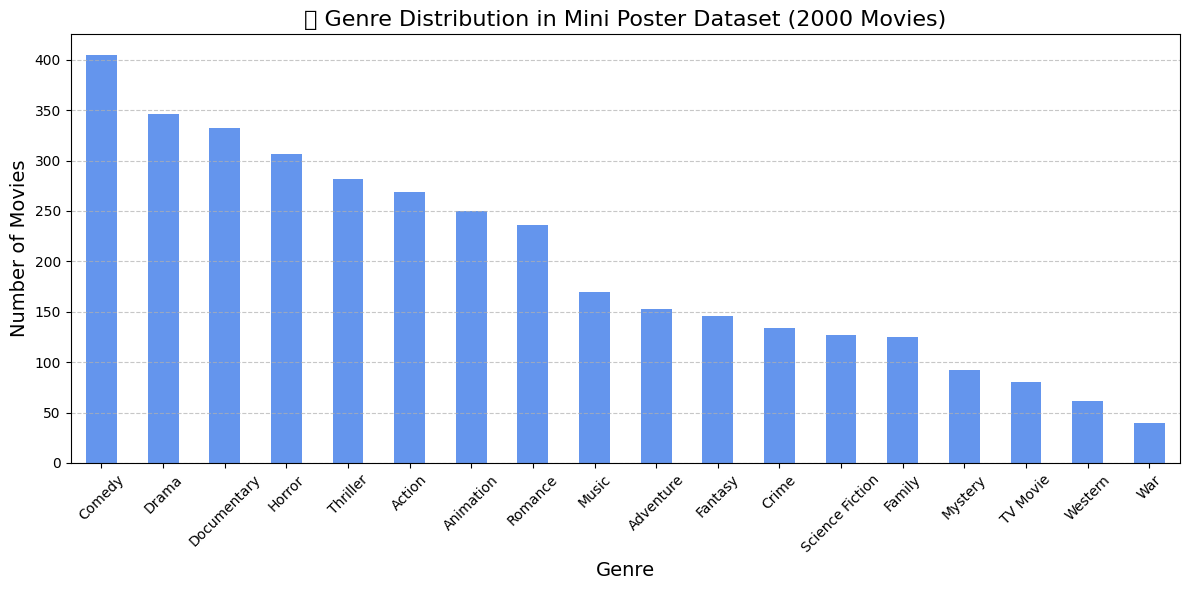

In [5]:
# Plot data
import matplotlib.pyplot as plt

# Define the genre columns you care about
genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror',
                 'Music', 'Mystery', 'Romance', 'Science Fiction',
                 'TV Movie', 'Thriller', 'War', 'Western']

# Count how many movies belong to each genre
genre_counts = mini_df[genre_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='cornflowerblue')
plt.title("🎬 Genre Distribution in Mini Poster Dataset (2000 Movies)", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Number of Movies", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
# Poster Dataset
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class PosterGenreDataset(Dataset):
    def __init__(self, dataframe, image_folder, genre_columns, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.genre_columns = genre_columns
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        poster_filename = row['poster_url'].split('/')[-1]
        img_path = os.path.join(self.image_folder, poster_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # If file not found, return a dummy black image
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        labels = row[self.genre_columns].values.astype('float32')

        return image, torch.tensor(labels)

In [15]:
# Image Transforms for Posters
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])


In [16]:
# Create dataset and DataLoader
from torch.utils.data import random_split, DataLoader

# Define genres again
genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror',
                 'Music', 'Mystery', 'Romance', 'Science Fiction',
                 'TV Movie', 'Thriller', 'War', 'Western']

# Create dataset
poster_dataset = PosterGenreDataset(mini_df, image_folder="mini_posters/", genre_columns=genre_columns, transform=transform)

# Split into train/val (e.g., 80%-20%)
train_size = int(0.8 * len(poster_dataset))
val_size = len(poster_dataset) - train_size
train_dataset, val_dataset = random_split(poster_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"✅ Train set: {len(train_dataset)} samples | Validation set: {len(val_dataset)} samples")


✅ Train set: 1600 samples | Validation set: 400 samples


In [17]:
# Pre-trained RESNET-18 Model
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Load ResNet-18 pretrained on ImageNet
resnet = models.resnet18(pretrained=True)

# 2. Modify the final FC layer
num_features = resnet.fc.in_features  # Number of input features to final layer
resnet.fc = nn.Linear(num_features, len(genre_columns))  # 18 genres

# 3. Move model to device
device = torch.device("cpu")
resnet = resnet.to(device)

print("✅ ResNet-18 loaded and modified for genre prediction!")

✅ ResNet-18 loaded and modified for genre prediction!


/opt/miniconda3/envs/tf-macos/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/tf-macos/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Train Set-UP
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

print("✅ Loss function and optimizer ready!")

✅ Loss function and optimizer ready!


In [19]:
# Training Loop
import torch.nn.functional as F
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Store training progress
train_losses = []
val_losses = []
train_micro_f1s = []
val_micro_f1s = []

def train_resnet(resnet, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        resnet.train()
        running_loss = 0
        y_true_train = []
        y_pred_train = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend((preds >= 0.5).astype(int))

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_micro = f1_score(y_true_train, y_pred_train, average='micro')
        train_micro_f1s.append(train_micro)

        # Validation after each epoch
        val_loss, val_micro = validate_resnet(resnet, val_loader)
        val_losses.append(val_loss)
        val_micro_f1s.append(val_micro)

        print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Micro-F1: {train_micro:.4f} | Val Loss: {val_loss:.4f} | Val Micro-F1: {val_micro:.4f}")

def validate_resnet(model, val_loader):
    model.eval()
    running_loss = 0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend((preds >= 0.5).astype(int))

    avg_val_loss = running_loss / len(val_loader)
    val_micro = f1_score(y_true_val, y_pred_val, average='micro')
    return avg_val_loss, val_micro

In [20]:
# Plot Results
def plot_training_curves(train_losses, val_losses, train_micro_f1s, val_micro_f1s):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Micro F1
    plt.subplot(1, 2, 2)
    plt.plot(train_micro_f1s, label="Train Micro-F1", marker='o')
    plt.plot(val_micro_f1s, label="Validation Micro-F1", marker='o')
    plt.title("Micro F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
# Train
train_resnet(resnet, train_loader, val_loader, epochs=5)

📚 Epoch 1/5 | Train Loss: 0.3239 | Train Micro-F1: 0.1068 | Val Loss: 0.4022 | Val Micro-F1: 0.0986
📚 Epoch 2/5 | Train Loss: 0.2748 | Train Micro-F1: 0.1506 | Val Loss: 0.3025 | Val Micro-F1: 0.1111
📚 Epoch 3/5 | Train Loss: 0.2533 | Train Micro-F1: 0.2671 | Val Loss: 0.3633 | Val Micro-F1: 0.1220
📚 Epoch 4/5 | Train Loss: 0.2280 | Train Micro-F1: 0.3833 | Val Loss: 0.3361 | Val Micro-F1: 0.2319
📚 Epoch 5/5 | Train Loss: 0.1978 | Train Micro-F1: 0.5033 | Val Loss: 0.3605 | Val Micro-F1: 0.2384


In [22]:
# Save model state_dict after training
torch.save(resnet.state_dict(), "poster_genre_classifier.pth")
print("✅ Trained poster model saved as 'poster_genre_classifier.pth'")


✅ Trained poster model saved as 'poster_genre_classifier.pth'


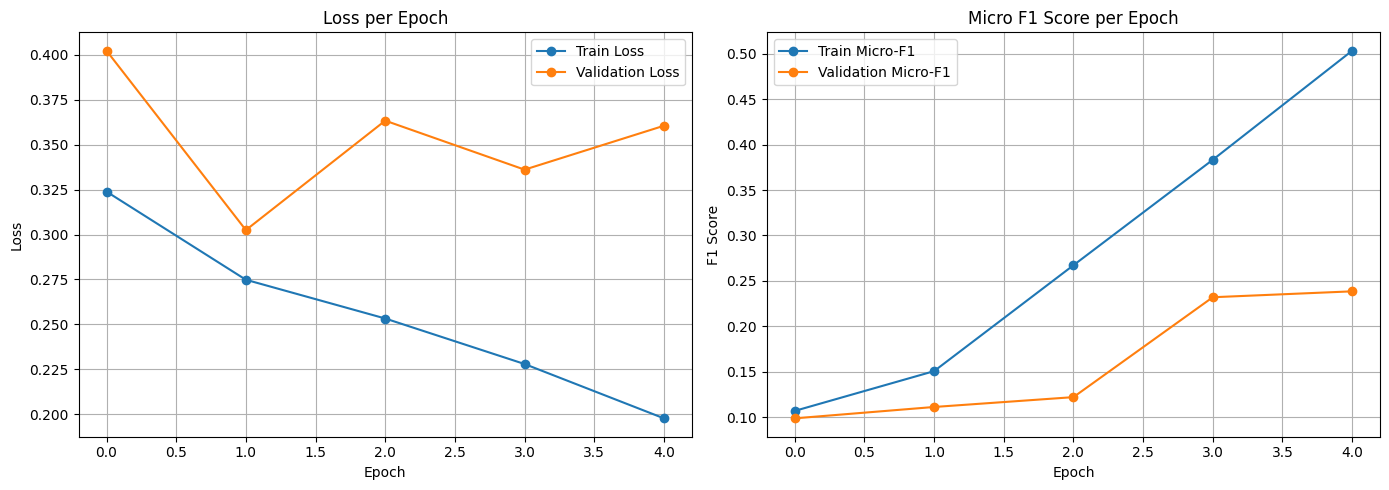

In [23]:
# Plot
plot_training_curves(train_losses, val_losses, train_micro_f1s, val_micro_f1s)


In [24]:
# Predict on trained
def predict_poster_genre(image_path, model, transform, genre_columns, threshold=0.5):
    from PIL import Image
    import torch

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        probs = torch.sigmoid(output).squeeze().numpy()

    # Apply threshold to get genres
    predicted_genres = [genre for genre, prob in zip(genre_columns, probs) if prob >= threshold]

    return predicted_genres


In [26]:
### Predict Function
# Assume you have a new poster image (local file)
import random
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show_posters(model, dataframe, image_folder, transform, genre_columns, num_images=10, threshold=0.5):
    model.eval()

    # Randomly select N images
    selected_rows = dataframe.sample(n=num_images, random_state=42)

    plt.figure(figsize=(20, 10))

    for idx, row in enumerate(selected_rows.itertuples()):
        poster_filename = getattr(row, 'poster_url').split('/')[-1]
        img_path = os.path.join(image_folder, poster_filename)

        try:
            # Load and transform
            image = Image.open(img_path).convert('RGB')
            input_img = transform(image).unsqueeze(0)

            # Predict
            with torch.no_grad():
                output = model(input_img)
                probs = torch.sigmoid(output).squeeze().numpy()

            # Genres above threshold
            predicted_genres = [genre for genre, prob in zip(genre_columns, probs) if prob >= threshold]

            # Plot
            plt.subplot(2, 5, idx+1)
            plt.imshow(image)
            plt.axis('off')
            title = "\n".join(predicted_genres) if predicted_genres else "No Genre"
            plt.title(title, fontsize=10)

        except FileNotFoundError:
            print(f"❌ Poster not found: {poster_filename}")
            continue

    plt.tight_layout()
    plt.show()



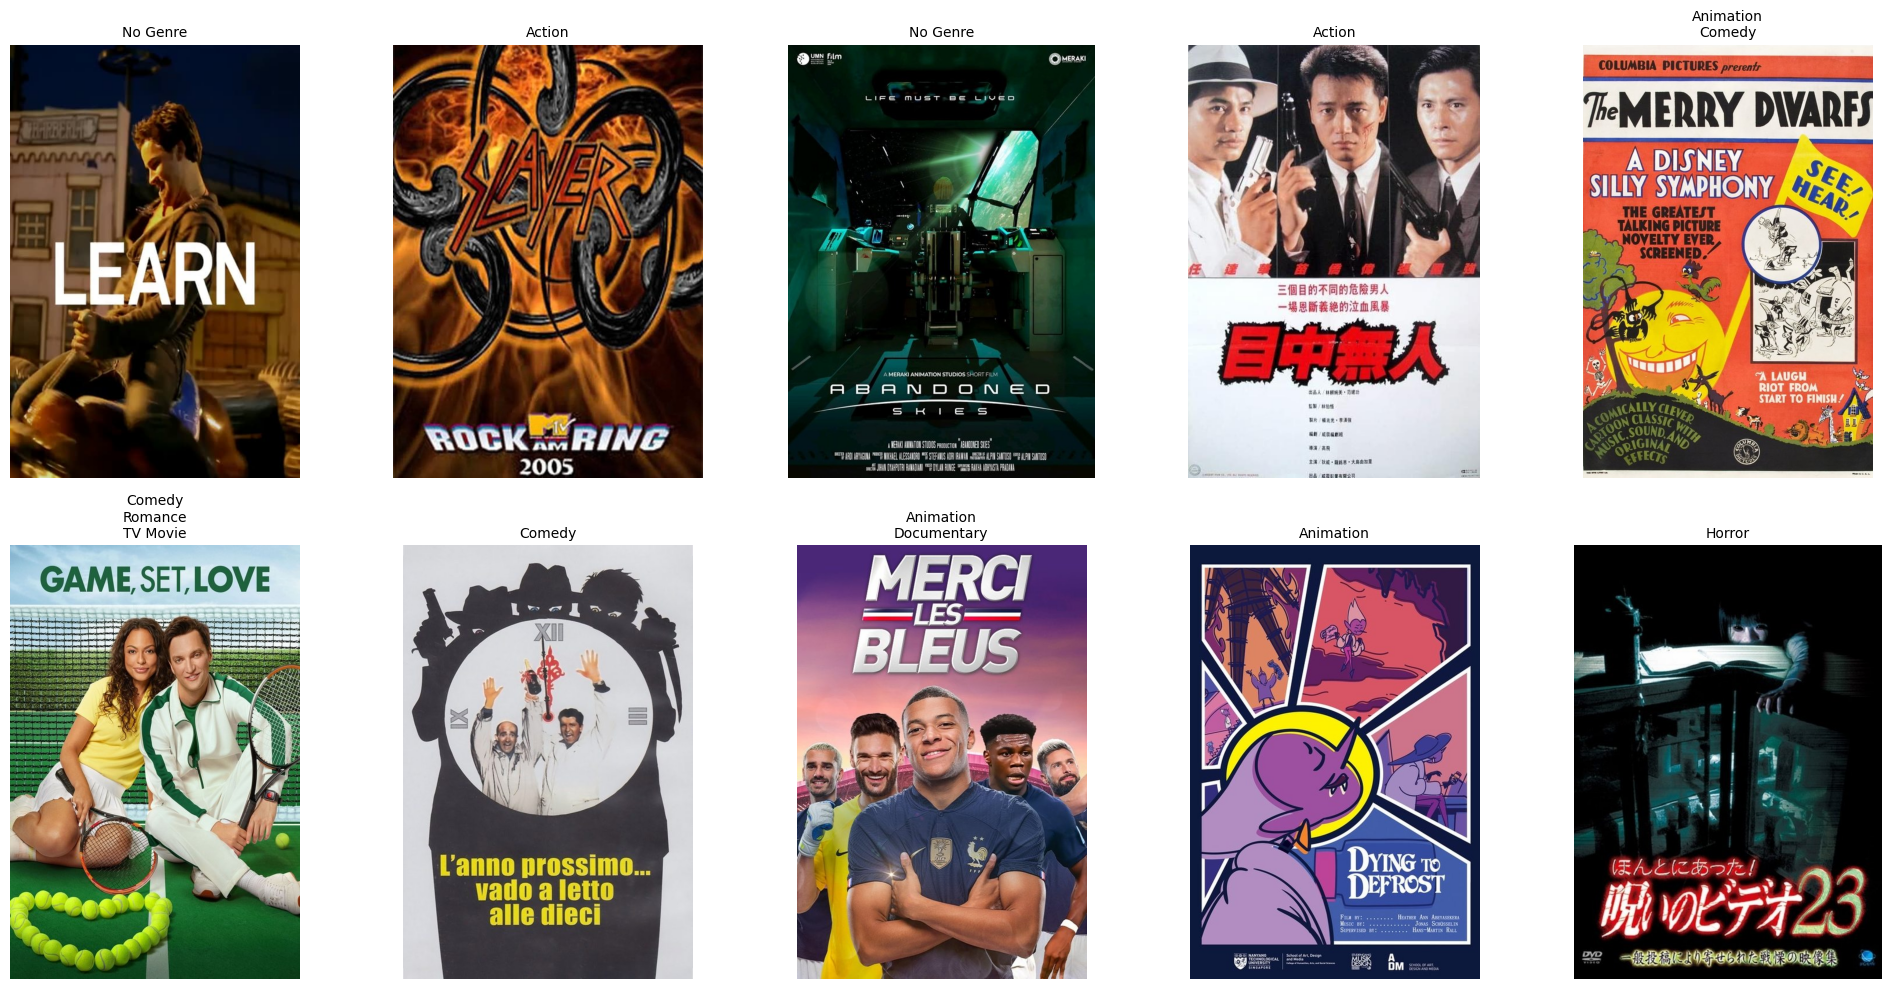

In [27]:
# Predict
predict_and_show_posters(resnet, mini_df, "mini_posters", transform, genre_columns, num_images=10, threshold=0.5)
